In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from config import config
import pickle
import shap

In [2]:
# se toma archivo pickle, si no existe se crea desde el csv generado en el script de R
df = pd.read_pickle('../data/vdem_coup_ML.pkl')

# drop non numeric columns for df pandas dataframe
df = df.select_dtypes(include=['number'])
df = df[df.columns[~df.columns.str.startswith('e_')]]
codebook = pd.read_excel('../data/codebook.xlsx')

# divido en X e y
X = df.drop(columns='coup')
y = df.set_index('year')['coup']

modelos = {}

In [195]:
def score(modelo):
    dic = {}
    
    # se toma información del modelo desde el config file
    config_ML = config(modelo)
    output         = config_ML['output']

    # cargamos modelo ya entrenado
    with open(output, 'rb') as f:
        clf = pickle.load(f)

    anios = range(2020,2024)
    
    dic['AUC'] = pd.DataFrame(index=anios)

    for anio in anios:        
        X_test, y_test           = X[X['year'] == anio], y[y.index == anio]
        X_test_acum, y_test_acum = X[X['year'].between(2020,anio)], y[(y.index>=2020) & (y.index<=anio)]
        
        y_pred = clf.predict(X_test)
                    
        y_pred_acum = clf.predict(X_test_acum)
        
        dic['AUC'].loc[anio,'AUC'] = roc_auc_score(y_test, y_pred)
        dic['AUC'].loc[anio,'AUC acumulada'] = roc_auc_score(y_test_acum, y_pred_acum)
    
    return dic

In [196]:
modelos['RF'] = score('RF')
modelos['XGB'] = score('XGB')

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [197]:
pd.concat((modelos['XGB']['AUC'],
           modelos['RF']['AUC']),axis=1,keys=['XGBoost','Random Forest'])

XGBoost               Random Forest              
           AUC AUC acumulada           AUC AUC acumulada
2020  1.000000      1.000000      1.000000      1.000000
2021  0.750000      0.785714      0.830443      0.855718
2022  0.666667      0.750000      0.666667      0.799051
2023  0.500000      0.692308      0.833333      0.806981

# Random Forest

In [198]:
with open('modelos/random_forest_sin_e.pkl', 'rb') as f:
    clf = pickle.load(f)

In [204]:
X_test  = X[X['year'].between(2020,2022)]
y_test  = y[(y.index>=2020) & (y.index<=2022)]
y_pred = clf.predict(X_test)

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [205]:
# import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       527
           1       0.86      0.60      0.71        10

    accuracy                           0.99       537
   macro avg       0.92      0.80      0.85       537
weighted avg       0.99      0.99      0.99       537



In [83]:
import json
with open('../data/country_codes.json') as f:
    country_codes = json.load(f)

In [84]:
resultados = df.loc[df['year'].between(2020,2022),['country_id','year','coup']]

resultados['coup_pred'] = y_pred
resultados['country_name'] = resultados['country_id'].astype(str).map(country_codes)

In [85]:
# add true positive, false positive, true negative and false negative to resultados
resultados['TP'] = (resultados['coup'] == 1) & (resultados['coup_pred'] == 1)
resultados['FP'] = (resultados['coup'] == 0) & (resultados['coup_pred'] == 1)
resultados['TN'] = (resultados['coup'] == 0) & (resultados['coup_pred'] == 0)
resultados['FN'] = (resultados['coup'] == 1) & (resultados['coup_pred'] == 0)

In [86]:
resultados.loc[resultados['TP'], 'Resultado'] = 'Verdadero positivo'
resultados.loc[resultados['FP'], 'Resultado'] = 'Falso positivo'
resultados.loc[resultados['TN'], 'Resultado'] = 'Verdadero negativo'
resultados.loc[resultados['FN'], 'Resultado'] = 'Falso negativo'

In [87]:
# replace coup and coup_pred with 'si' and 'no'
resultados['coup'] = resultados['coup'].replace({1:'Sí',0:'No'})
resultados['coup_pred'] = resultados['coup_pred'].replace({1:'Sí',0:'No'})

In [88]:
resultados[resultados['FN']]

,country_id,year,coup,coup_pred,country_name,TP,FP,TN,FN,Resultado
1719,28,2021,Sí,No,Mali,False,False,False,True,Falso negativo
3929,60,2021,Sí,No,Niger,False,False,False,True,Falso negativo
8045,119,2022,Sí,No,Guinea-Bissau,False,False,False,True,Falso negativo
11575,196,2022,Sí,No,Sao Tome and Principe,False,False,False,True,Falso negativo


In [89]:
resultados[resultados['TP']]

,country_id,year,coup,coup_pred,country_name,TP,FP,TN,FN,Resultado
589,10,2021,Sí,Sí,Burma/Myanmar,True,False,False,False,Verdadero positivo
1718,28,2020,Sí,Sí,Mali,True,False,False,False,Verdadero positivo
2028,33,2021,Sí,Sí,Sudan,True,False,False,False,Verdadero positivo
3486,54,2022,Sí,Sí,Burkina Faso,True,False,False,False,Verdadero positivo
4151,63,2021,Sí,Sí,Guinea,True,False,False,False,Verdadero positivo
7344,109,2021,Sí,Sí,Chad,True,False,False,False,Verdadero positivo


In [90]:
print(resultados.loc[resultados['Resultado'].isin(['Verdadero positivo','Falso negativo']),
           ['year','country_name','coup','coup_pred','Resultado']]\
          .rename(columns={'year':'Año',
                           'country_name':'País',
                           'coup':'¿Hubo golpe?',
                           'coup_pred':'Predicción'})\
          .sort_values('Año')\
          .sort_values(['Resultado'],ascending=False).to_latex(index=False))

\begin{tabular}{rllll}
\toprule
Año & País & ¿Hubo golpe? & Predicción & Resultado \\
\midrule
2020 & Mali & Sí & Sí & Verdadero positivo \\
2021 & Burma/Myanmar & Sí & Sí & Verdadero positivo \\
2021 & Sudan & Sí & Sí & Verdadero positivo \\
2021 & Guinea & Sí & Sí & Verdadero positivo \\
2021 & Chad & Sí & Sí & Verdadero positivo \\
2022 & Burkina Faso & Sí & Sí & Verdadero positivo \\
2021 & Mali & Sí & No & Falso negativo \\
2021 & Niger & Sí & No & Falso negativo \\
2022 & Guinea-Bissau & Sí & No & Falso negativo \\
2022 & Sao Tome and Principe & Sí & No & Falso negativo \\
\bottomrule
\end{tabular}



In [91]:
codebook_tag = codebook[['tag','question']]
for lag in [1,5,10]:

    lag = pd.concat((codebook['tag']+'_lag_1',codebook['question']+' (lag 1)'),axis=1)
    codebook_tag = pd.concat((codebook_tag,lag),axis=0)
codebook_tag.rename(columns={'question':'Pregunta','tag':'Variable'},inplace=True)

In [92]:
import numpy as np

In [93]:
# create a dataframe with feature importances and column name
feat_imp = pd.DataFrame(zip(X.columns,clf.feature_importances_), columns=['Variable','Importancia'])
feat_imp.sort_values('Importancia',ascending=False,inplace=True)

feat_imp['Importancia acumulada'] = np.cumsum(feat_imp['Importancia'])
feat_imp = pd.merge(feat_imp,codebook_tag,how='left')

In [182]:
feat_imp_labs = [
'Días desde comienzo del régimen',
'¿El régimen terminó por un golpe de estado (año anterior)',
'¿El ejecutivo no es más electo?',
'¿Legislatura cerrada o abortada?',
'Proceso más importante para terminar con un régimen (año anterior)',
'Influencia de las FFAA sobre el Poder Ejecutivo',
'FFA se movilizan contra el régimen?',
'¿golpes de estado en el último año?',
'Influencia de las FFAA sobre el Poder Ejecutivo (año anterior)',
'¿Cómo llega el jefe de estado al gob?']

In [206]:
tab_feat_imp = feat_imp[['Variable','Importancia','Importancia acumulada']]\
    .sort_values('Importancia',ascending=False)\
        .drop_duplicates().head(10).reset_index(drop=True)

In [217]:
tab_feat_imp['Variable ext'] = feat_imp_labs

In [ ]:
print(tab_feat_imp.head(10).to_latex(index=False,float_format='%.3f'))

# Shapley values

In [3]:
with open('modelos/random_forest_sin_e.pkl', 'rb') as f:
    clf = pickle.load(f)

In [4]:
X_test  = X[X['year'].between(2020,2022)]
y_test  = y[(y.index>=2020) & (y.index<=2022)]
y_pred = clf.predict(X_test)

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py:2153: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [5]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:327: RuntimeWarning: invalid value encountered in cast
  X = X.astype(self.model.input_dtype)


In [6]:
#tomo variables más importantes visualizadas en el gráfico de shapley values
# shap.violin_plot(shap_values[:,:,1], X_test,max_display=30,
                #  feature_names=X_imp_labs,plot_size=1)

imp_feat_labs = {
'coup_lag_1'         :'¿golpes de estado en el último año?',
'v2expathhs'         : '¿Cómo llega el jefe de estado al gob?',
'v2regdur'           :'Días desde comienzo del régimen',
'v2regoppgroupsact_5':'FFA se movilizan contra el régimen?',
'v2elrgpwr_lag_5'    :'¿Se enseña en la primaria contenidos\ncon valores políticos? (lag 5)',
'v2edpoledprim_lag_5':'Poder relativo entre miembros electos\ny no electos a nivel regional (lag 5)',
'v2elpeace':'Violencia durante período electoral',
'v2x_ex_military':'Influencia de las FFAA sobre\nel Poder Ejecutivo',
'v2x_ex_military_lag_1':'Influencia de las FFAA sobre\nel Poder Ejecutivo (año anterior)',
'v2elrgpwr_lag_10':'Poder relativo entre miembros electos\ny no electos a nivel regional (lag 10)',
'v2x_hosinter':'¿El ejecutivo no es más electo?',
'v2regendtypems_0_lag_1':'¿El régimen terminó por\nun golpe de estado (año anterior)',
'v2xlg_leginter':'¿Legislatura cerrada o abortada?',
'v2regendtype_lag_1':'Proceso más importante para\nterminar con un régimen (año anterior)'
}

X_imp_labs = X.columns.map(lambda x: imp_feat_labs[x] if x in imp_feat_labs.keys() else x)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
values = pd.DataFrame(shap_values[:,:,1],columns=X_imp_labs)[list(imp_feat_labs.values())].melt()
values = values.sort_values('value',ascending=False)

In [63]:
import locale
locale.setlocale(locale.LC_ALL, 'es_ES')

'es_ES'

c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_violin.py:194: RuntimeWarning: invalid value encountered in scalar add
  running_sum += values[sort_inds[leading_pos]]
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_violin.py:197: RuntimeWarning: invalid value encountered in scalar subtract
  running_sum -= values[sort_inds[trailing_pos]]


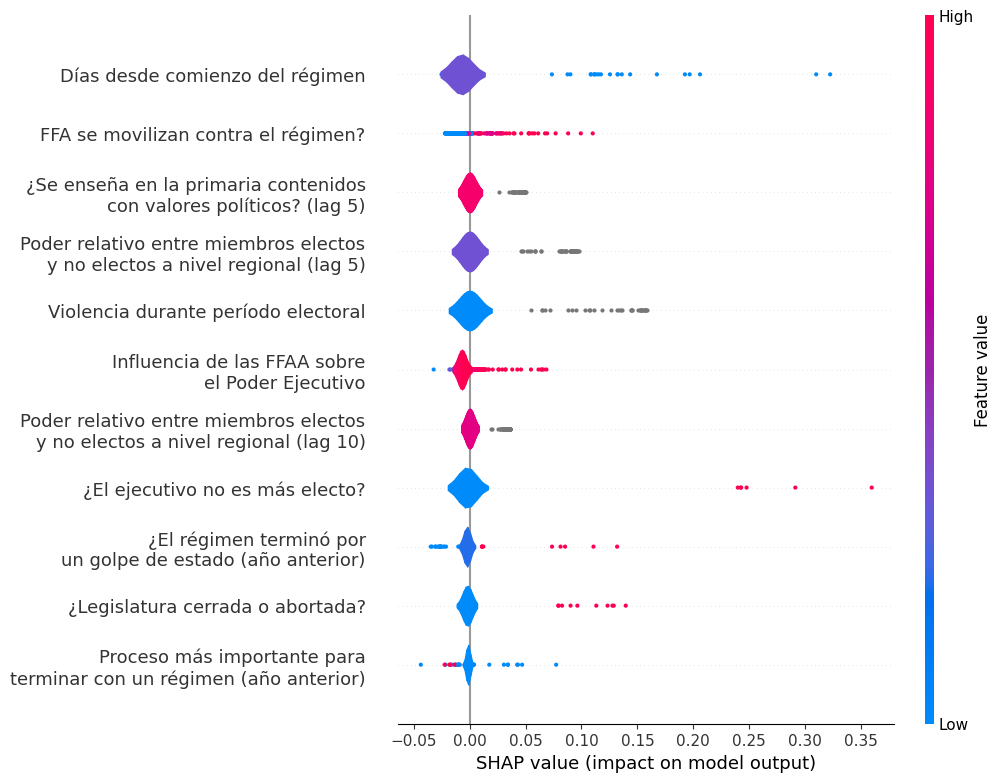

<Figure size 640x480 with 0 Axes>

In [64]:
shap.violin_plot(shap_values[:,:,1], X_test,max_display=11,
                 feature_names=X_imp_labs,plot_size=.7)
plt.show()
plt.savefig('../entregas/imagenes/7_shapley_values.png')


c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\joses\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


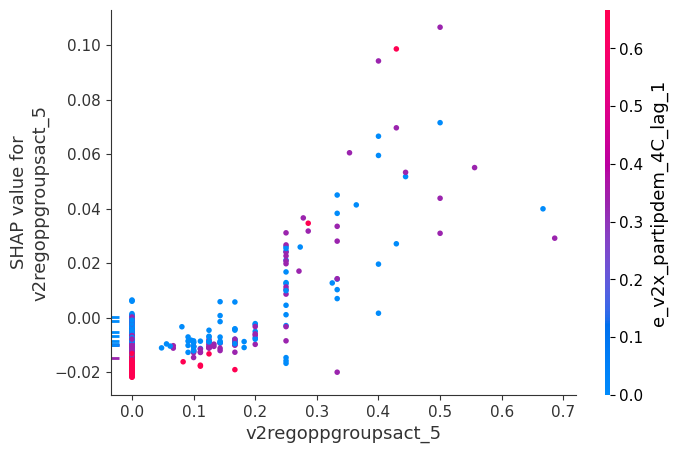

In [47]:
shap.dependence_plot("v2regoppgroupsact_5", shap_values[:,:,1], X_test)